In [1]:
import sys
import os
base_path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(base_path)

import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import json
import os
import time
from common import setup_env
from models import build_tokenizer, build_model
from tasks import load_task 
from utils.llm_layers import add_icv_layers, remove_icv_layers
from utils.data_utils import load_and_prepare_dataset

from tqdm import tqdm
from utils.tools import tokenize_each_demonstration, apply_template, apply_template_knowledge, apply_template_math, apply_template_symbolic, apply_template_graph, apply_template_classifier
from utils.eval_utils import obtain_majority_answers, check_response_accuracy, load_formatting_prompt, load_previous_results, extract_answer
from utils.score_outputs import get_output_win_rate

from utils.score_outputs import get_prm_score


from transformers import logging
logging.set_verbosity_error()

class Evaluator:
    def __init__(self, args, init_prompt, ds_args, prm_model_args, gen_model_args, root_path='./records'):
        """
        Evaluator class to evaluate the performance of a model on a dataset with or wihout latent shifting.

        Args:
            args (dict): Dictionary containing arguments such as num_trials, alpha_mode, model_type, model_size, dataset, split.
            init_prompt (str): Initial prompt to be used for the evaluation.
            ds_args (dict): Dictionary containing dataset arguments such as dataset name and split.
            prm_model_args (dict): Dictionary containing PRM model arguments such as model name and device.
            gen_model_args (dict): Dictionary containing generation model arguments such as model type, size, GPUs, cuda device, seed, and 8-bit flag.
            root_path (str, optional): Path to save the evaluation records. Defaults to './records'.
        """
        if not os.path.exists(root_path):
            os.makedirs(root_path)

        self.init_prompt = init_prompt
        self.root_path = root_path
        self.prm_model_args = prm_model_args
        self.ds_args = ds_args
        self.gen_model_args = gen_model_args
        self.dataset = load_and_prepare_dataset(ds_args)
        self.alpha_mode = args.alpha_mode
        self.template = args.template
        # Initialize PRM tokenizer and model
        self.tokenizer = build_tokenizer(
            gen_model_args['model_type'], gen_model_args['model_size'], padding_side="right"
        )
        self.gen_model = build_model(
            gen_model_args['model_type'], gen_model_args['model_size'], gen_model_args['in_8bit'], gen_model_args['cuda_device']
        )

        if 'R1' in gen_model_args['model_type']:
            self.eval_model = build_model(
                'Qwen2.5', '7b', False
            )
            self.eval_tokenizer = build_tokenizer(
                'Qwen2.5', '7b', padding_side="left"
            )
        else:
            self.eval_model = self.gen_model
            self.eval_tokenizer = self.tokenizer

        if 'llama' in gen_model_args['model_type']:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        torch.autograd.set_grad_enabled(False)

        self.formatting_prompt = load_formatting_prompt(ds_args['dataset_name'])

        if 'musr' in ds_args['dataset_name']:
            dataset_demo = [{'question': item['final_question'], 'answer': item['answer']} for item in self.dataset]
        else:
            dataset_demo = [{'question': item['question'], 'answer': item['answer']} for item in self.dataset]
        # Apply templates to the demo dataset
        if 'knowledge' in self.template:
            demos_with_templates = apply_template_knowledge(dataset_demo, self.tokenizer)
        elif 'math' in self.template:
            demos_with_templates = apply_template_math(dataset_demo, self.tokenizer)
        elif 'symbolic' in self.template:
            demos_with_templates = apply_template_symbolic(dataset_demo, self.tokenizer)
        elif 'graph' in self.template:
            demos_with_templates = apply_template_graph(dataset_demo, self.tokenizer)
        elif 'classifier' in self.template:
            demos_with_templates = apply_template_classifier(dataset_demo, self.tokenizer)
        else:
            demos_with_templates = apply_template(dataset_demo, self.tokenizer)
        self.icvs_to_shift = self.prepare_icv(demos_with_templates, rank=1, n=256)
        
    def get_embedding(self, text_or_texts):
        """
        Accept either a single str or a list of strs.
        Returns a single numpy vector (if single input) or list of vectors (if list input).
        """
        single = isinstance(text_or_texts, str)
        texts = [text_or_texts] if single else text_or_texts

        # Batch tokenize/pad
        encoded = self.eval_tokenizer(texts, return_tensors="pt", padding=True,
                                    truncation=True, max_length=1024).to(self.eval_model.device)

        with torch.no_grad():
            outputs = self.eval_model(**encoded, output_hidden_states=True, use_cache=False)

        last_hidden = outputs.hidden_states[-1]  # [batch, seq_len, hidden]
        emb = last_hidden.mean(dim=1).cpu().numpy()  # (batch, hidden)

        return emb[0] if single else [e for e in emb]
    
    def prepare_icv(self, demos_with_templates, n=256, rank=1):
        """
        Prepares the ICV (Inverse Concept Variance) by sampling and tokenizing data.
        """
        # Load TaskHandler and apply templates
        TaskHandler = load_task('demo')
        task_agent = TaskHandler('default')
        task_agent.set_seed(0)

        demos_with_templates = demos_with_templates[0:n]
        # Ensure no ICV layers remain in the model
        try:
            while True:
                remove_icv_layers(self.gen_model)
        except Exception:
            pass
        
        print('==================calculating icv==================')
        icv_cot, _ = task_agent.obtain_icv(
            self.gen_model,
            tokenize_each_demonstration(demos_with_templates, self.tokenizer, prefix=("", "")),
            rank=rank
        )

        icv_cot = icv_cot[1:]

        return torch.stack([icv_cot], dim=1)   
    
    def clean_icv_layers(self):
        try:
            while True:
                remove_icv_layers(self.gen_model)
        except:
            pass

    def generate_without_icv(self, input_ids, num_return_sequences=5):
        """
        Generates text without ICV applied.

        Args:
            input_ids (torch.Tensor): Input IDs tensor.
            num_return_sequences (int, optional): The number of sequences to return. Defaults to 5.

        Returns:
            List[str]: List of generated text.
        """
        self.clean_icv_layers()
        decoded_output = self.generate(input_ids, num_return_sequences=num_return_sequences)
        return decoded_output
    
    def generate_with_icv(self, input_ids, alpha, num_return_sequences=5):
        """
        Generates text with ICV applied.

        Args:
            input_ids (torch.Tensor): Input IDs tensor.
            alpha (float or list): Alpha value(s) for ICV.
        """

        self.clean_icv_layers()
        if not isinstance(alpha, list):
            alpha = [alpha]
        add_icv_layers(self.gen_model, self.icvs_to_shift.cuda(self.gen_model.device), alpha)
        decoded_output = self.generate(input_ids, num_return_sequences=num_return_sequences)
        return decoded_output

    def formatting_final_answers(self, eval_model, eval_tokenizer, query, best_generation, formatting_prompt):
        """
        Formats the final answers from the generated text.

        Args:
            query (str): The original query.
            best_generation (list): List of generated text.
        """
        final_answers = []
        for response_each in best_generation:
            messages_query_final_answer = [
            {"role": "system", "content": "You job is to extract the final short answer from the more detailed answer."},
            {"role": "user", "content": formatting_prompt.format(query=query, reasoning=response_each)},
        ]
        
            input_ids_final_answer = eval_tokenizer.apply_chat_template(
                messages_query_final_answer, add_generation_prompt=True, return_tensors="pt"
            ).to(eval_model.device)

            current_data_final = eval_model.generate(input_ids_final_answer, num_return_sequences=1, max_new_tokens=256)[0]
            current_data_final = eval_tokenizer.decode(current_data_final[len(input_ids_final_answer[0]):], skip_special_tokens=True)
            if 'gsm8k' in self.ds_args['dataset_name']:
                current_data_final = current_data_final.replace(',', '')
            final_answers.append(current_data_final)
        return final_answers

    def get_exp_name(self, model_type, dataset_name, start_sample, n_samples, num_trials, alpha_mode, alpha_a, alpha_b):
        return f"{model_type.replace('/','-')}_{dataset_name.replace('/','-')}_{start_sample}_{n_samples}_ntrials_{num_trials}_alpha_mode_{alpha_mode}_alpha_a_{alpha_a}_alpha_b_{alpha_b}"



/home/woodywu/Desktop/Research/Steering/FractionalReason/fr_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import argparse
# parser = argparse.ArgumentParser(description='ICV Arguments')
# parser.add_argument('--num_trials', type=int, default=20, help='Number of trials for generation')
# parser.add_argument('--model_type', type=str, default='llama-3', help='model to use')
# parser.add_argument('--model_size', type=str, default='8b', help='model size to use')
# parser.add_argument('--dataset', type=str, default='gsm8k', choices=['gsm8k', 'HuggingFaceH4/MATH-500', 'Idavidrein/gpqa', 'woodywu/APBench'], help='dataset to use')
# parser.add_argument('--split', type=str, default='test', help='split of the dataset to use')
# parser.add_argument('--alpha_mode', type=str, default='uniform', help='uniform or normal')
# parser.add_argument('--root_path', type=str, default='./records/plain_majority_vote', help='root path to save the records')
# parser.add_argument('--num_samples', type=int, default=-1, help='number of samples to use')
# parser.add_argument('--alpha_a', type=float, default=0, help='lower bound of the alpha range')
# parser.add_argument('--alpha_b', type=float, default=0.15, help='upper bound of the alpha range')
# parser.add_argument('--cuda_device', type=int, default=0, help='Cuda device (single) to use')

# your chosen values
num_trials = 1
num_samples = 50
cuda_device = 1
# model_type = "Qwen2.5"
model_type = "llama-3"
# model_size = "7b"
model_size = "8b"
dataset = "woodywu/APBench"

# Build args directly from local variables (no parsing of notebook argv)
args = argparse.Namespace(
    num_trials=1,
    model_type=model_type,
    model_size=model_size,
    dataset=dataset,
    split='test',
    alpha_mode='uniform',
    root_path='./records/plain_majority_vote',
    num_samples=num_samples,
    alpha_a=0.0,
    alpha_b=0.15,
    cuda_device=cuda_device
)

# Original single-process usage
gen_model_args = {
    "model_type": args.model_type,
    "model_size": args.model_size,
    "gpus": [0,1],
    "cuda_device": args.cuda_device,
    "seed": 42,
    "in_8bit": True
}

prm_model_args = {
    "prm_model_name": "RLHFlow/Llama3.1-8B-PRM-Deepseek-Data",
    "prm_device": "auto"
}

dataset_args = {
    "dataset_name": args.dataset,
    "split": args.split
}

start_sample = 0

print(torch.cuda.is_available())

start_time = time.time()
# Initialize generation model and tokenizer
setup_env(gpu_s=gen_model_args['gpus'], seed=gen_model_args['seed'])

init_prompt = 'Solve the problem. Put your final answer within \\boxed{{}}.'
# CoT
args.template = "cot"
args.cuda_device = 1
gen_model_args['cuda_device'] = args.cuda_device
evaluator_cot = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
icv_cot = evaluator_cot.icvs_to_shift
# Squeeze the singleton middle dimension and convert to NumPy
arr_cot = icv_cot.squeeze().detach().cpu().numpy()

# # knowledge
# args.template = "knowledge"
# args.cuda_device = 0
# gen_model_args['cuda_device'] = args.cuda_device
# evaluator_know = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
# icv_know = evaluator_know.icvs_to_shift
# arr_know = icv_know.squeeze().detach().cpu().numpy()

# # math
# args.template = "math"
# args.cuda_device = 0
# gen_model_args['cuda_device'] = args.cuda_device
# evaluator_math = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
# icv_math = evaluator_math.icvs_to_shift
# arr_math = icv_math.squeeze().detach().cpu().numpy()

# # symbolic
# args.template = "symbolic"
# args.cuda_device = 1
# gen_model_args['cuda_device'] = args.cuda_device
# evaluator_symbolic = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
# icv_symbolic = evaluator_symbolic.icvs_to_shift
# arr_symbolic = icv_symbolic.squeeze().detach().cpu().numpy()

# # graph
# args.template = "graph"
# args.cuda_device = 1
# gen_model_args['cuda_device'] = args.cuda_device
# evaluator_graph = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
# icv_graph = evaluator_graph.icvs_to_shift
# arr_graph = icv_graph.squeeze().detach().cpu().numpy()

# # classifier
# # graph
# args.template = "classifier"
# args.cuda_device = 1
# gen_model_args['cuda_device'] = args.cuda_device
# evaluator_classifier = Evaluator(args, init_prompt, dataset_args, prm_model_args, gen_model_args, root_path=args.root_path)
# icv_classifier = evaluator_classifier.icvs_to_shift
# arr_classifier = icv_classifier.squeeze().detach().cpu().numpy()


exp_name = f"{gen_model_args['model_type'].replace('/','-')}_{dataset_args['dataset_name'].replace('/','-')}"
# Save as vector PDF for scalable output
output_file_path = os.path.join(evaluator_cot.root_path, exp_name + "_heatmap.pdf")

True


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Applying general CoT
==================calculating icv==================


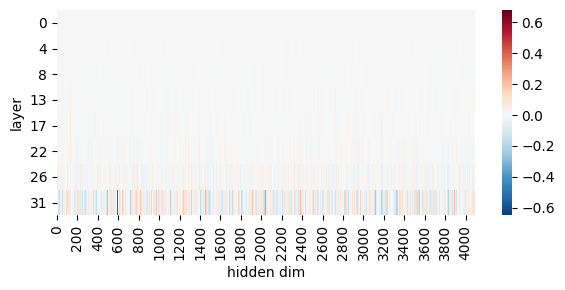

In [4]:
# ---- signed log transform ----
def signed_log(x, eps=1e-12):
    # sign(x) * log(1 + |x|)
    return np.sign(x) * np.log1p(np.abs(x) + eps)

# ---- apply transform before plotting ----
arr_log = signed_log(arr_cot)

import matplotlib.pyplot as plt
import seaborn as sns
# Choose how many layer rows you want to show in the heatmap (e.g. 8)
num_layers_to_show = 8

# Select layer indices evenly spaced across the full layer range (0..27)
layer_indices = np.linspace(0, arr_log.shape[0] - 1, num=num_layers_to_show, dtype=int)

# Create a reduced array containing only the selected rows
arr_subset = arr_log[layer_indices, :]

plt.figure(figsize=(6, 3))
# show the subset heatmap; don't let seaborn auto-set yticklabels
sns.heatmap(arr_subset, cmap='RdBu_r', center=0, 
            xticklabels=200,  # keep your existing x tick spacing
            yticklabels=False) # we'll set yticks manually below

# Map tick positions (0..num_layers_to_show-1) to original layer numbers
ytick_positions = np.arange(len(layer_indices))
ytick_labels = layer_indices.astype(str)

plt.yticks(ytick_positions + 0.5, ytick_labels)  # +0.5 centers ticks on heatmap cells
plt.xlabel('hidden dim')
plt.ylabel('layer')
# plt.title('ICV heatmap (layers x hidden) — sampled layers')
plt.tight_layout()
plt.savefig(output_file_path,format='pdf',bbox_inches='tight')
plt.show()



/home/woodywu/Desktop/Research/Steering/FractionalReason/fr_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


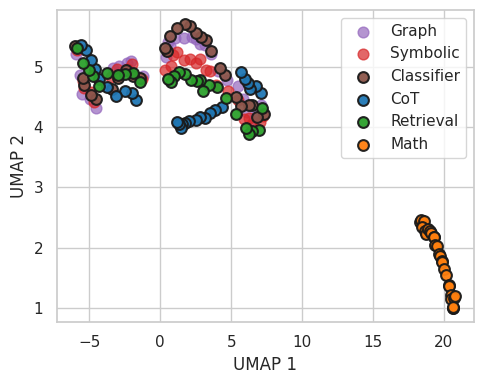

In [42]:
import umap
X = np.vstack([arr_cot, arr_know, arr_math, arr_symbolic, arr_graph, arr_classifier])
# --- build labels that match row counts ---
labels = (
    ["CoT"] * arr_cot.shape[0] +
    ["Math"] * arr_math.shape[0] +
    ["Retrieval"] * arr_know.shape[0] +
    ["Symbolic"] * arr_symbolic.shape[0] +
    ["Graph"] * arr_graph.shape[0] +
    ["Classifier"] * arr_classifier.shape[0]
)
labels = np.array(labels)

# UMAP 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X)   # shape (N, 2)

# --- plotting ---
sns.set(style="whitegrid")
plt.figure(figsize=(5,4))
palette = {"CoT":"tab:blue", "Math":"tab:orange", "Retrieval":"tab:green", 
           "Symbolic":"tab:red", "Graph":"tab:purple", "Classifier":"tab:brown"}
unique_labels = np.unique(labels)
# choose which classes to emphasize
emphasize = ["Classifier", "CoT", "Retrieval", "Math"]

normal_plot = [lbl for lbl in unique_labels if lbl not in emphasize]
# plot individual points
for lbl in normal_plot:
    mask = labels == lbl
    pts = X_umap[mask]
    plt.scatter(pts[:,0], pts[:,1], s=60, alpha=0.7, label=lbl, color=palette.get(lbl, None))


ax = plt.gca()
for lbl in emphasize:
    mask = labels == lbl
    pts = X_umap[mask]
    # bigger points with black edge
    h = ax.scatter(pts[:,0], pts[:,1], s=60, alpha=0.95, color=palette.get(lbl),label=lbl,
                   edgecolor="k", linewidth=1.5, zorder=5)

plt.legend()
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.tight_layout()

plt.savefig('UMAP_projection_ICVs.pdf', format='pdf', bbox_inches='tight')
plt.show()
